In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from tqdm import tqdm
import glob
import os
import time
from IPython.display import clear_output

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

In [2]:
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
folder = 'C:/Users/oryan/Documents/mergers-in-cosmos'
student_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/followup-data'
results_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-results'
cosmos_folder = 'E:/cosmos-data'
fits_folder = 'E:/cosmos-fits'

In [3]:
with fits.open(f'{cosmos_folder}/COSMOS2020_CLASSIC_R1_v2.1_p3.fits.gz') as hdul:
    data = hdul[1].data

In [6]:
df = pd.read_csv(f'{data_folder}/cosmos-primary-data.csv', index_col = 0).reset_index().rename(columns = {'index' : 'SourceID'})[['SourceID', 'ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST','lp_mass_best']]

In [7]:
files = glob.glob(f'{fits_folder}/*.fits')

In [10]:
df.query('lp_mass_best < 12.5 and lp_mass_best > 6.5')

,SourceID,ID,ALPHA_J2000,DELTA_J2000,ez_z_phot,lp_zBEST,lp_mass_best
0,4000705532455,816891,150.679846,2.196543,0.519525,0.5304,9.28590
1,4000705532984,857121,150.673667,2.226291,0.219858,0.2235,10.49288
2,4000705533312,873195,150.668102,2.242849,0.346519,0.3024,10.18078
3,4000705533383,861738,150.645118,2.237538,0.619803,0.6224,9.36051
4,4000705539529,1284864,149.686223,2.637412,0.705821,0.6984,10.17034
...,...,...,...,...,...,...,...
3779,6000534269373,1193387,150.588619,2.546616,0.883769,NaN,9.92413
3781,6000535064806,1041748,150.435644,2.404769,1.091646,NaN,9.08741
3783,6000535781610,1231637,150.428931,2.588176,0.538722,0.4988,8.52516
3784,6000535864481,1042682,150.505365,2.407106,NaN,1.4406,6.95391


In [7]:
sourceid = int(os.path.basename(files[1]).replace('.fits',''))

In [8]:
ra = df.query('SourceID == @sourceid')['ALPHA_J2000'].iloc[0]
dec = df.query('SourceID == @sourceid')['DELTA_J2000'].iloc[0]
z_ez = df.query('SourceID == @sourceid')['ez_z_phot'].iloc[0]
z_lp = df.query('SourceID == @sourceid')['lp_zBEST'].iloc[0]
id_str = df.query('SourceID == @sourceid')['ID'].iloc[0]

In [9]:
z_ez

0.21985808

In [10]:
z_lp

0.2235

In [11]:
def picking_z(ez_z, lp_z):
    if np.isnan(ez_z):
        if not np.isnan(lp_z):
            return lp_z
        else:
            return np.nan
    
    if np.isnan(lp_z):
        if not np.isnan(ez_z):
            return ez_z
        else:
            return np.nan
    
    if lp_z < ez_z:
        return lp_z
    elif ez_z <= lp_z:
        return ez_z
    else:
        return 'what'

In [12]:
def getting_secondary(ra, dec, z, prim_id):
    record = data[(data['ALPHA_J2000'] > ra - (15 / (60*60))) & (data['ALPHA_J2000'] < ra + (15 / (60*60))) & (data['DELTA_J2000'] > dec - (15 / (60*60))) & (data['DELTA_J2000'] < dec + (15 / (60*60)))]
    
    df = Table(record).to_pandas()[['ID', 'ALPHA_J2000', 'DELTA_J2000', 'ez_z_phot', 'lp_zBEST']]
    
    df_z = (
        df
        .assign(redshift = df.apply(lambda row: picking_z(row.ez_z_phot, row.lp_zBEST), axis = 1))
        .drop(columns = ['ez_z_phot', 'lp_zBEST'])
        .dropna()
        .query('ID != @prim_id')
    )   
    
    return df_z

In [13]:
df_secs = getting_secondary(ra, dec, z_ez, id_str)

In [14]:
df_secs = df_secs.query('redshift <= 1.5')

In [15]:
with fits.open(files[0]) as hdul:
    im_data = hdul[0].data
    header = hdul[0].header

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


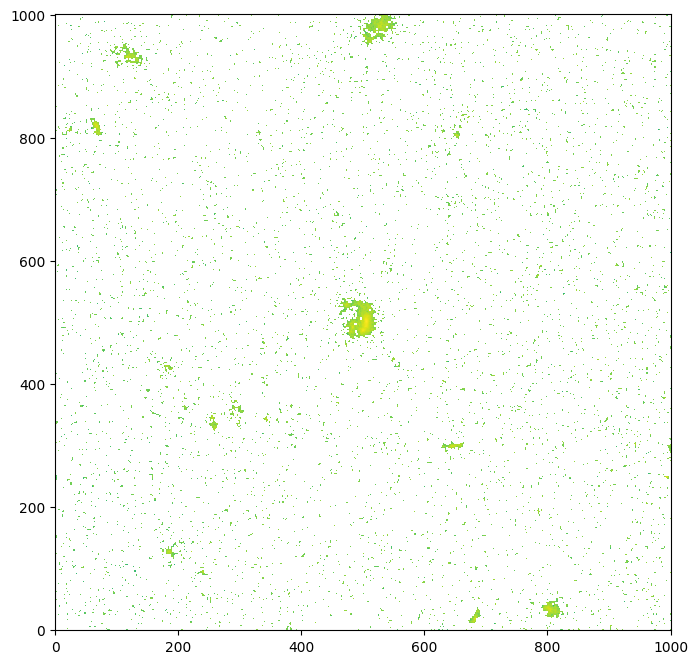

In [16]:
plt.figure(figsize = (8,8))
plt.imshow(np.log10(im_data), origin = 'lower')
plt.show()

In [17]:
df_coords = (
    df_secs
    .assign(coords = df.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
)

In [18]:
coords_list = list(df_coords.coords)

In [19]:
w = WCS(header)

In [20]:
pixs_list = []
for i in coords_list:
    pixs_list.append(skycoord_to_pixel(i, w, origin = 0))
pixs_arr = np.array(pixs_list)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


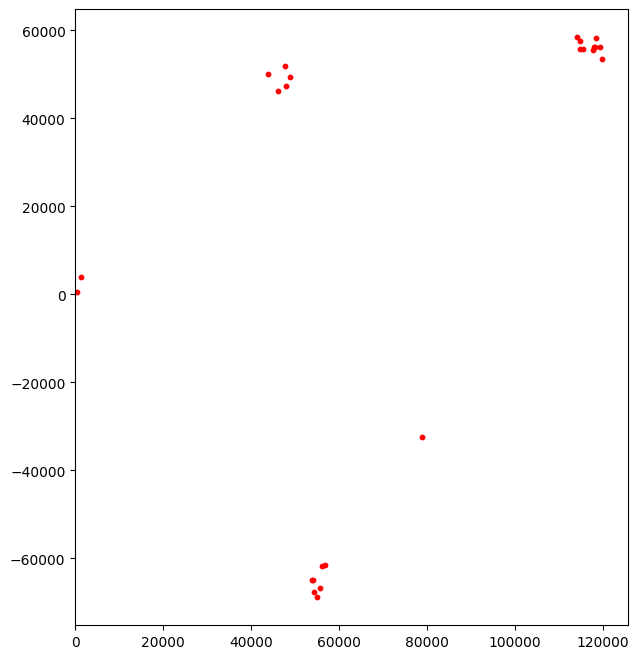

In [21]:
plt.figure(figsize = (8,8))
plt.imshow(np.log10(im_data), origin = 'lower')
plt.scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
plt.show()

### Looping Through

In [90]:
secondaries = {}
if os.path.exists(f'{data_folder}/secondaries-identified.csv'):
    df_secs = pd.read_csv(f'{data_folder}/secondaries-identified.csv', index_col = 0)
    secondaries = df_secs.to_dict()['0']

In [91]:
len(df_secs)

3657

In [92]:
len(df)

3786

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in log10


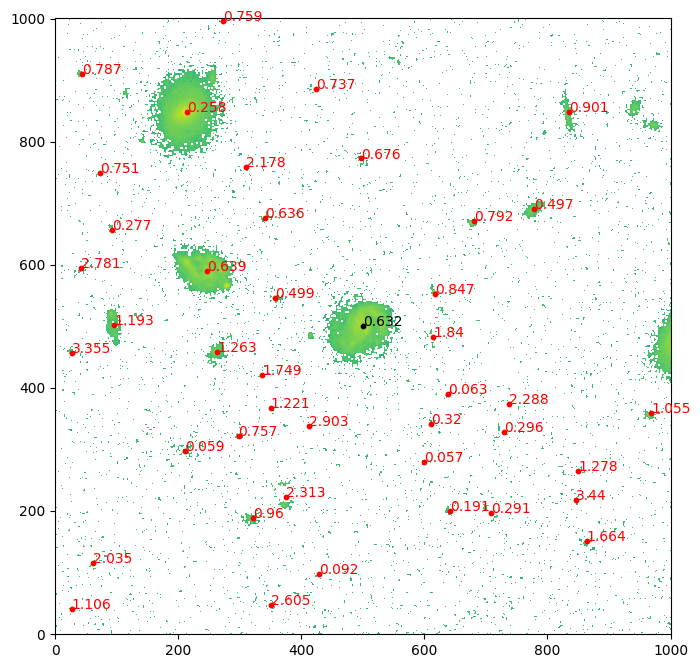

Is the Secondary marked? y


In [93]:
for counter, i in enumerate(files):    
    sourceid = int(os.path.basename(i).replace('.fits',''))
    
    if sourceid in list(secondaries.keys()):
        counter += 1
        continue
    
    ra = df.query('SourceID == @sourceid')['ALPHA_J2000'].iloc[0]
    dec = df.query('SourceID == @sourceid')['DELTA_J2000'].iloc[0]
    z_ez = df.query('SourceID == @sourceid')['ez_z_phot'].iloc[0]
    z_lp = df.query('SourceID == @sourceid')['lp_zBEST'].iloc[0]
    id_str = df.query('SourceID == @sourceid')['ID'].iloc[0]
    
    redshift = picking_z(z_ez, z_lp)
    if redshift > 1.5:
        secondaries[sourceid] = 'l'
        continue
    
    prim_coord = SkyCoord(ra = ra * u.deg, dec = dec * u.deg, frame = 'fk5')
    
    df_secs = getting_secondary(ra, dec, z_ez, id_str)
    
    with fits.open(i) as hdul:
        im_data = hdul[0].data
        header = hdul[0].header
    
    w = WCS(header)
        
    df_coords = (
        df_secs
        .assign(coords = df_secs.apply(lambda row: SkyCoord(ra = row.ALPHA_J2000 * u.deg, dec = row.DELTA_J2000 * u.deg, frame = 'fk5'), axis = 1))
    )
    
    coords_list = list(df_coords.coords)
    z_list = list(df_coords.redshift)
    
    pixs_list = []
    for j in coords_list:
        pixs_list.append(skycoord_to_pixel(j, w, origin = 0))
    pixs_arr = np.array(pixs_list)
    
    prim_pix = np.array(skycoord_to_pixel(prim_coord, w, origin = 0))
    
    fig, ax = plt.subplots(figsize = (8,8))
    ax.imshow(np.log10(im_data), origin = 'lower')
    ax.scatter(prim_pix[0], prim_pix[1], s = 10, color='black')
    ax.annotate(np.round(redshift, 3), (prim_pix[0], prim_pix[1]), color = 'black')
    ax.scatter(pixs_arr[:,0], pixs_arr[:,1], s = 10, color = 'red')
    for i, txt in enumerate(z_list):
        ax.annotate(np.round(txt, 3), (pixs_arr[i,0], pixs_arr[i,1]), color = 'red')
    plt.show()
    
    if counter % 10 == 0:
        print(np.round(counter / len(files), 2))
    
    secondaries[sourceid] = input('Is the Secondary marked?')
    
    clear_output(wait = True)

Key for criteria:

    y - Secondary Identifiable
    n - Secondary Unidentifiable
    b - Wrong Primary Idenfied
    nm - Likely not a merger
    l - Redshift out of range.

In [94]:
df_secs = pd.DataFrame.from_dict(secondaries, orient = 'index')

In [95]:
df_secs

,0
4000705532455,n
4000705532984,nm
4000705533312,y
4000705533383,n
4000705539435,l
...,...
6000536185363,nm
6000536185496,n
6000536185585,b
6000536185603,nm


In [96]:
df_secs.loc[6000531278906] = 'nm'

In [97]:
df_secs[0].value_counts()

n      2186
y       755
nm      441
l       248
b       149
m         2
nn        1
nm.       1
nnm       1
n#        1
nbm       1
Name: 0, dtype: int64

In [98]:
df_secs.to_csv(f'{data_folder}/secondaries-identified.csv')